# Stolen Base Success

This could really use more data. For stealing second base, I have formulas that work for each season, or in the case of season 15, *almost* work. But some of them are rather "overfit"-feeling, and also the Season 15 one has 2 stubborn outliers I don't know what to do with. Fitting to all seasons at once (for rolls below 0.95) actually does really well too (9 outliers out of 2185), so I don't know to what extent the variation I'm seeing in these formulas actually is real...

Of note: The clearest change I can see in the data is that they added a cutoff for the threshold in season 14. For S14 and S15, no roll above 0.95 can be a success

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [2]:
all_files = glob.glob("../roll_data/*-steal_success.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [12]
seasons = [11, 12, 13, 14]
# seasons = [13]
# seasons = [14]
df = df[df["season"].isin(seasons)]
len(df)

11357

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_runner_mul(row):
    bm = str(row["runner_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.05
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    # if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
    #     mul += 0.5
    # if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        # mul += 1.0
        # attrs = "runner_musclitude, runner_divinity, runner_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        # attrs = "runner_musclitude, runner_laserlikeness, runner_ground_friction, runner_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        # mul += 1.25
        pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["runner_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul#, attrs

def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul


In [4]:
df["runner_mul"] = df.apply(get_runner_mul, axis=1)
# df[["runner_mul", "runner_mul_attrs"]] = df.apply(get_runner_mul, axis=1, result_type="expand")
# df["runner_mul"] = df.apply(lambda x: 1, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
# df["pitcher_mul"] = df.apply(lambda x: 1, axis=1)
# df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [5]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["runner_mods"].astype(str).str.contains("SCATTERED"), "runner_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [6]:
for attr in [
    "runner_base_thirst",
    "runner_continuation",
    "runner_ground_friction",
    "runner_indulgence",
    "runner_laserlikeness",
]:
    # had to do all this to make chunky and smooth work correctly
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["runner_mul"] * (1 + 0.2 * x["runner_vibes"])
    #                               if (x["runner_mul_attrs"] == "") or (attr in x["runner_mul_attrs"])
    #                               else x[attr] * (1 + 0.2 * x["runner_vibes"]),
    #                               axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["runner_mul"] * (1 + 0.2 * df["runner_vibes"])

In [7]:
df = df.copy()
for attr in [
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
]:
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])
    #                           if (x["pitcher_mul_attrs"] == "") or (attr in x["pitcher_mul_attrs"])
    #                           else x[attr] * (1 + 0.2 * df["pitcher_vibes"]),
    #                           axis=1)
    df[attr + "_mul"] = df[attr] * df["pitcher_mul"]
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

In [8]:
if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])
        #                       if (x["fielder_mul_attrs"] == "") or (attr in x["fielder_mul_attrs"])
        #                       else x[attr] * (1 + 0.2 * df["fielder_vibes"]),
        #                       axis=1)
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])


df = df.copy()

In [9]:
df.groupby("event_type").size().sort_values(ascending=False)[0:15]

event_type
StealSuccess0    7430
StealSuccess1    3500
StealSuccess2     427
dtype: int64

In [10]:
# focus on stealing *second base* because it has the largest sample size
# dfc = df[df["event_type"] == "StealSuccess1"].copy()
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
# for exclude_mod in ["SPICY", "ON_FIRE"]:
# dfc = dfc[~dfc["runner_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["runner_mul"] == 1) & (dfc["fielder_mul"] == 1)]

dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5
dfc["incon_center"] = dfc["ballpark_inconvenience"] - 0.5
# dfc = dfc[dfc['stadium_id'].isna()]

len(dfc)

8677

In [11]:
dfc[dfc['passed']].loc[:, 'roll'].max()

0.9987812941996794

In [12]:
X = dfc[
    [
        "roll",
        "passed",
        "runner_laserlikeness_mul_vibe",
        "pitcher_anticapitalism_mul",
        "fielder_anticapitalism_mul_vibe",
        "elong_center",
        # "incon_center",
    ]
]
X = X[X['roll'] < 0.95]

y = X["passed"]
X = X.drop("passed", axis=1)

pin_intercept = None
pin_intercept = 0.65
pins = [
    ( 0.45, 'runner_laserlikeness_mul_vibe'),
    (-0.10, 'pitcher_anticapitalism_mul'),
    (-0.30, 'fielder_anticapitalism_mul_vibe'),
    (-0.15, 'elong_center'),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
dfc["threshold_plot"] = dfc["threshold"].copy()

[[1439    1]
 [   6 6782]]
7 outliers
0.9991492464754497
intercept: 0.65
(0.45, 'runner_laserlikeness_mul_vibe')
(-0.1, 'pitcher_anticapitalism_mul')
(-0.3, 'fielder_anticapitalism_mul_vibe')
(-0.15, 'elong_center')


## Best formulas so far

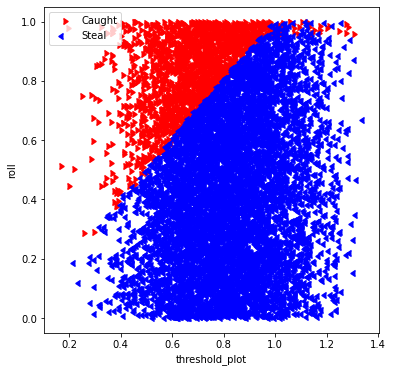

In [13]:
# this works for season 12, with no maximum threshold cutoff!
# if season == 11:
# dfc.loc[(dfc["season"] == 11), "threshold"] = (0.65
#                                                + 0.45 * dfc["runner_laserlikeness_mul_vibe"]
#                                                - 0.30 * dfc["fielder_anticapitalism_mul_vibe"]
#                                                - 0.10 * dfc["pitcher_anticapitalism_mul"]
#                                                - 0.20 * dfc["elong_center"]
#                                               )

# this works for season 13, with no maximum threshold cutoff!
# if season == 12:
# dfc.loc[(dfc["season"] == 12), "threshold"] = (0.65
#                                                + 0.45 * dfc["runner_laserlikeness_mul_vibe"]
#                                                - 0.30 * dfc["fielder_anticapitalism_mul_vibe"]
#                                                - 0.10 * dfc["pitcher_anticapitalism_mul"]
#                                                - 0.20 * dfc["elong_center"]
#                                               )

# this works for season 14
# there IS a threshold at 0.95 in season 14!
# if season == 13:
# dfc.loc[(dfc["season"] == 13), "threshold"] = (0.65
#                                                + 0.45 * dfc["runner_laserlikeness_mul_vibe"]
#                                                - 0.30 * dfc["fielder_anticapitalism_mul_vibe"]
#                                                - 0.10 * dfc["pitcher_anticapitalism_mul"]
#                                                - 0.15 * dfc["elong_center"]
#                                               )
dfc.loc[((dfc["threshold"] > 0.95) & (dfc["season"] == 13)), "threshold"] = 0.95


# this *almost* works for season 15; there are 1 or 2 outliers I can't get rid of.
# there IS a threshold at 0.95 in season 15!
# if season == 14:
# dfc.loc[(dfc["season"] == 14), "threshold"] = (0.65
#                                                + 0.45 * dfc["runner_laserlikeness_mul_vibe"]
#                                                - 0.30 * dfc["fielder_anticapitalism_mul_vibe"]
#                                                - 0.10 * dfc["pitcher_anticapitalism_mul"]
#                                                - 0.15 * dfc["elong_center"]
#                                               )
dfc.loc[((dfc["threshold"] > 0.95) & (dfc["season"] == 14)), "threshold"] = 0.95


# this will use the most recent fit values
# dfc["threshold"] = -intercept_scaled[0]
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]

# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95

y_val = "roll"
x_val = "threshold_plot"
# x_val = "elong_center"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Caught",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_title(f"Season {season+1} Steal Success")
# ax.set_ylim(0, 1.0)

if x_val == "threshold" or x_val == "svc":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

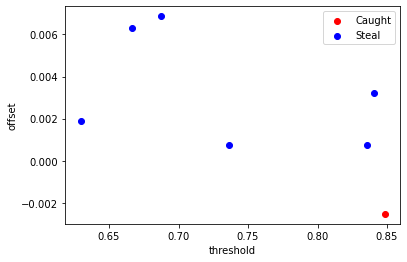

In [14]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "runner_laserlikeness_mul_vibe"
# x_val = "pitcher_anticapitalism_mul_vibe"
# x_val = "fielder_anticapitalism_mul_vibe"
# x_val = "elong_center"
# x_val = "runner_vibes"
# x_val = "pitcher_vibes"
# x_val = "fielder_vibes"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Caught",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Steal",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [15]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold",
        "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "runner_mul",
        "fielder_mul",  # "baserunner_count",
        # "runner_vibes", "pitcher_vibes",
        "runner_laserlikeness_mul_vibe",
        "pitcher_anticapitalism_mul_vibe",
        "fielder_anticapitalism_mul_vibe",
        "elong_center",
        "runner_name",
        "pitcher_name",
        "fielder_name",
        "runner_mods",
        "pitcher_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
        "weather",
    ]
]
print(len(table))
print(sum(np.abs(table.loc[:,"offset"])))
table.sort_values("offset", ascending=False)#[0:10]

7
0.022338406880669126


,passed,offset,roll,threshold,event_type,pitcher_mul,runner_mul,fielder_mul,runner_laserlikeness_mul_vibe,pitcher_anticapitalism_mul_vibe,fielder_anticapitalism_mul_vibe,elong_center,runner_name,pitcher_name,fielder_name,runner_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,weather
8366,True,0.006866,0.694053,0.687188,StealSuccess0,1.0,1.0,1.0,0.637883,1.163621,0.373917,0.055106,Ren Hunter,Ronan Jaylee,Zephyr McCloud,NaN,<NA>,<NA>,BIRD_SEED,<NA>,13,28,c1a95c9a-cd9b-45b4-9d5e-751c5346088a,177,Weather.FLOODING
6916,True,0.006305,0.672880,0.666575,StealSuccess0,1.0,1.0,1.0,0.853119,0.911272,0.942306,-0.014456,Glabe Moon,Oscar Vaughan,Rodriguez Internet,SIPHON;PERK,ALTERNATE,ALTERNATE;FIRE_EATER;REPEATING,BIRD_SEED,MIDDLING,14,91,f2f0ba6f-46f0-4011-b76a-3780d8efe7fb,120,Weather.REVERB
1514,True,0.003235,0.843617,0.840382,StealSuccess1,1.0,1.0,1.0,0.850073,0.994627,0.376802,-0.057019,Squid Galvanic,Zoey Kirchner,Bottles Suljak,NaN,<NA>,<NA>,CARCINIZATION;EXTRA_STRIKE,MAINTENANCE_MODE,12,55,e3c19cf5-190a-4c55-9b2d-c4625c62a835,207,Weather.BLACK_HOLE
5567,True,0.001882,0.631393,0.629511,StealSuccess0,1.0,1.0,1.0,0.541950,0.646786,0.601623,0.062553,Igneus Delacruz,Becker Solis,Yrjö Kerfuffle,ALTERNATE;CHUNKY,<NA>,<NA>,BASE_INSTINCTS,<NA>,14,53,3cbc2870-b333-4875-b93f-f816453b4fe3,43,Weather.FLOODING
3683,True,0.000771,0.836171,0.835400,StealSuccess0,1.0,1.0,1.0,1.104758,0.120581,0.964333,0.071378,-imon -a-ey,Patty Fox,Sandie Turner,FLINCH;SCATTERED,<NA>,SPICY;PERK,TRAVELING,BIRD_SEED,14,31,54a5948c-2942-4d15-badc-02d9d367f04f,214,Weather.FLOODING
6985,True,0.000753,0.736845,0.736092,StealSuccess1,1.0,1.0,1.0,0.909774,1.351658,0.687486,-0.057019,T-t -ox,Curry Aliciakeyes,Oscar Dollie,FLINCH;SCATTERED,OVERUNDER,<NA>,CARCINIZATION;UNHOLEY,O_NO,14,93,f9e2f13a-adc4-46ff-a226-a01029f47e23,330,Weather.SALMON
4093,False,-0.002527,0.845957,0.848483,StealSuccess1,1.0,1.0,1.0,0.969953,0.314780,0.652017,0.047139,Kelvin Drumsolo,Jenkins Good,Jesús Koch,NaN,ALTERNATE;FRIEND_OF_CROWS,ALTERNATE,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS,HIGH_PRESSURE,14,45,a7e9bce9-c57b-4b2c-ac69-decb5fb5717a,168,Weather.FEEDBACK


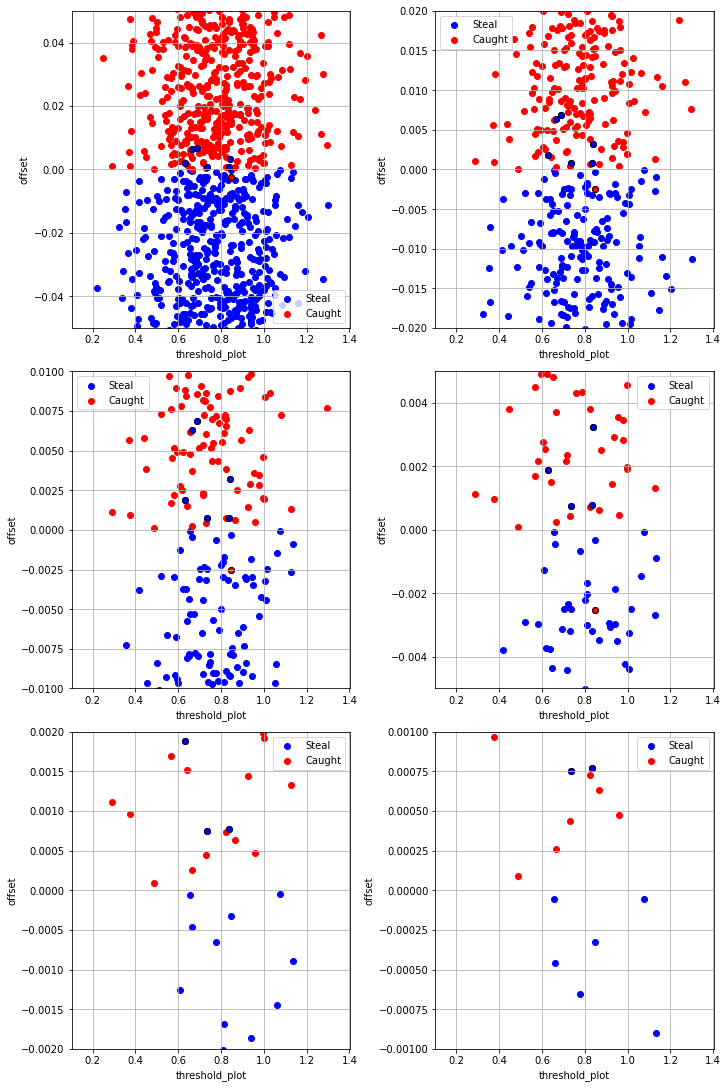

In [16]:
plt.rcParams["font.size"] = 10
x_val = "threshold_plot"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Steal",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Caught",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')

In [17]:
# pd.set_option("display.max_rows", None)

# dfc.loc[2050, ['roll', 'threshold']]